HPSS demo - can't by me love

In [23]:
import utilities
import features
import dataloader
import librosa
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
import madmom

def harmonicPercussiveResidualSeparation(sig,beta=2,n_fft=1024,fs=22050):
    time_filter_length = 0.2 # seconds
    frequency_filter_length = 500 # Hz
    hs = n_fft // 2 # hopsize
    X = librosa.stft(sig,n_fft=n_fft,hop_length=hs,window='hann', center=True, pad_mode='constant')
    Y = np.abs(X) ** 2
    L_med_f = int(frequency_filter_length / (fs/n_fft))
    L_med_t = int(time_filter_length / (hs /fs))

    Y_p = scipy.ndimage.median_filter(Y, (L_med_f,1))
    Y_h = scipy.ndimage.median_filter(Y, (1,L_med_t))

    M_h = Y_h / (Y_p+np.finfo(float).eps) > beta
    M_p = Y_p / (Y_h+np.finfo(float).eps) >= beta
    M_r = np.logical_not(M_h + M_p)

    X_h = M_h * X
    X_p = M_p * X
    X_r = M_r * X

    y_harm = librosa.istft(X_h,n_fft=n_fft,hop_length=hs,window='hann', center=True, length=sig.size)
    y_perc = librosa.istft(X_p,n_fft=n_fft,hop_length=hs,window='hann', center=True, length=sig.size)
    y_res = librosa.istft(X_r,n_fft=n_fft,hop_length=hs,window='hann', center=True, length=sig.size)
    
    return y_harm,y_perc,y_res

dataset = dataloader.Dataloader("beatles","/home/max/ET-TI/Masterarbeit/mirdata/")
audiopath,annotationspath = dataset["0307"]  # 0607  , 0307 can't by me love
t, sig = utilities.loadAudio(audiopath, t_start=0,t_stop=20)
annotations = utilities.loadAnnotations(annotationspath)
# Nh =4096 and Np =256
y_harm,y_perc,y_res = harmonicPercussiveResidualSeparation(sig,n_fft=4096,beta=1.5)
y_harm2,y_perc2,y_res2 = harmonicPercussiveResidualSeparation(y_perc+y_res,n_fft=256)


/home/max/.local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


(0.0, 10.0)

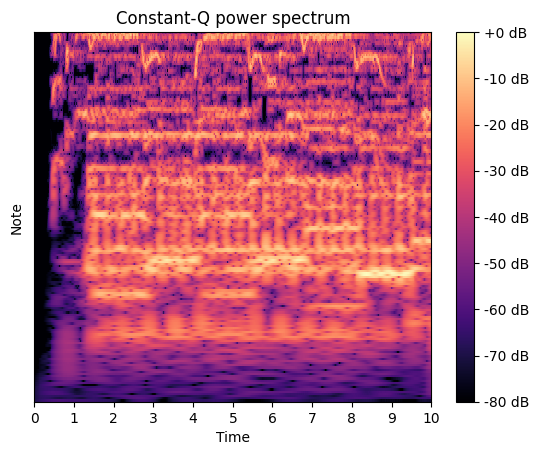

In [38]:
sr = 22050
C = np.abs(librosa.cqt(y_harm, sr=sr,bins_per_octave=36,n_bins=3*84))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
ax.set_xlim(0,10)

DEMO: Voice with piano - Queen Don't stop me now
The effect of source separation on the chromagram is investigated and discussed in this plot


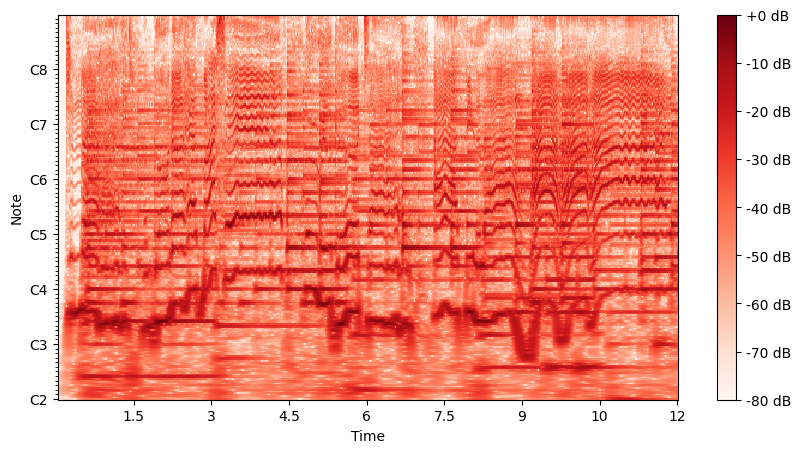

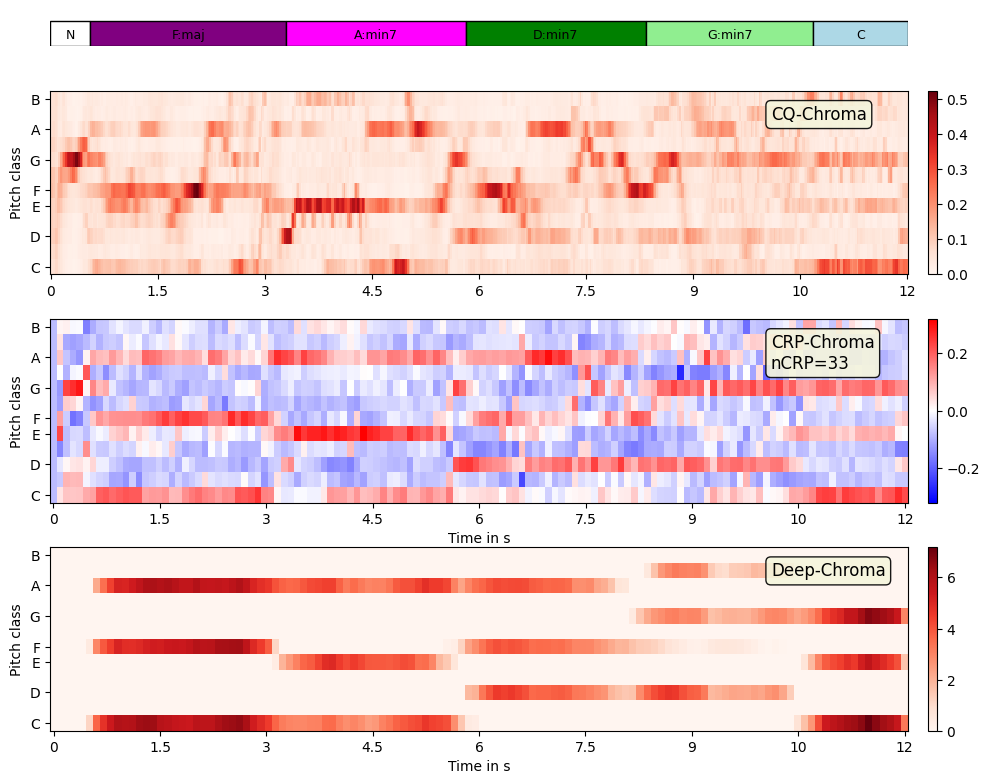

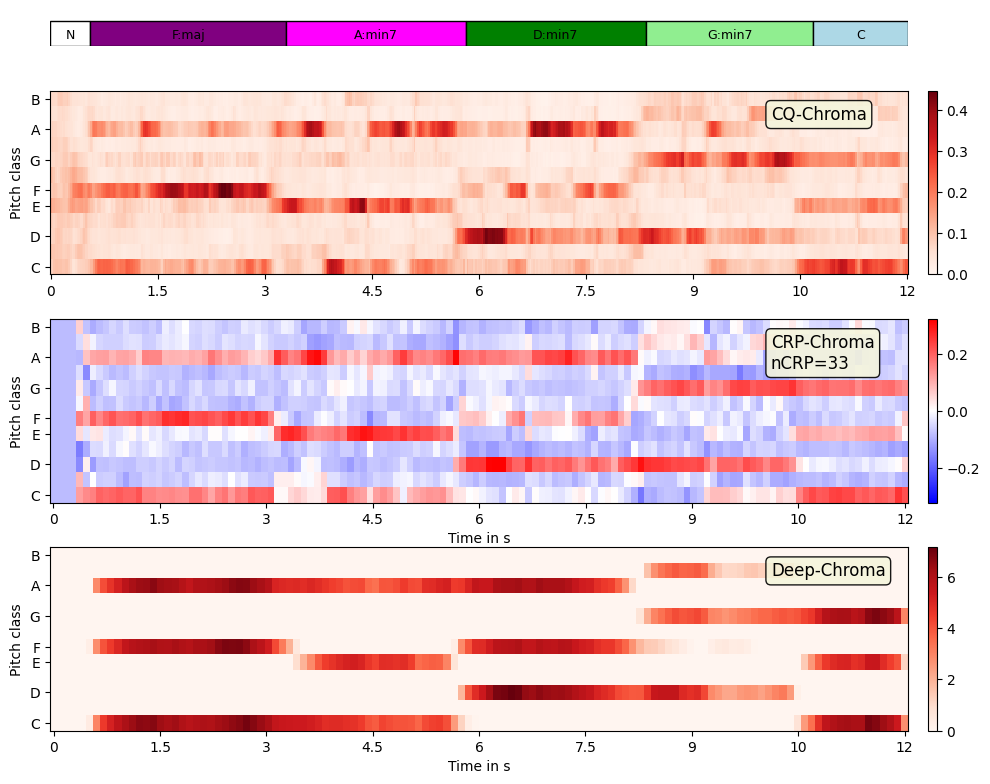

In [4]:
import matplotlib.pyplot as plt
import utilities
import features
import librosa.display
import mirdata
import numpy as np

queendataset = mirdata.initialize("queen","/home/max/ET-TI/Masterarbeit/mirdata/queen")
audiopath = queendataset.track("6").audio_path
harmonic_audiopath = audiopath.rsplit(".flac")[0] + "_harmonic+drums.mp3"
annotationspath = queendataset.track("6").chords_path
_,signal = utilities.loadAudio(audiopath,t_stop=12)
_,signal_harmonic = utilities.loadAudio(harmonic_audiopath,t_stop=12)
gt = utilities.loadAnnotations(annotationspath)
t_cq,cq = features.cqt(signal)

# CQT of mix
fig,ax = plt.subplots(figsize=(10,5))
img=librosa.display.specshow(librosa.amplitude_to_db(cq,ref=np.max),ax=ax,hop_length=2048,cmap="Reds",sr=22050,bins_per_octave=36,x_coords=t_cq,
                         x_axis="time",y_axis="cqt_note",key="F:maj",fmin=librosa.midi_to_hz(36),fmax=librosa.midi_to_hz(36)*(2**7))
fig.colorbar(img,ax=ax,format="%+2.f dB")

# ISOLATED VOCALS
nCRP = 33
t_cqt_vocals,cqt_chroma_vocals = features.cqtChroma(signal)
t_crp_vocals,crp_chroma_vocals = features.crpChroma(signal,nCRP=nCRP,window=True,liftering=True)
t_dcp,deep_chroma = features.deepChroma(signal,5)


fig,((ax0,ax01), (ax1,ax11),(ax2,ax22),(ax3,ax33)) = plt.subplots(4,2,height_ratios=(2,10,10,10),
                                        width_ratios=(10,0.1), figsize=(10,8))
utilities.plotChordAnnotations(ax0,gt,(0,12))
img = utilities.plotChromagram(ax1,t_cqt_vocals,cqt_chroma_vocals,chroma_type="cqt");
ax1.text(0.84, 0.92,"CQ-Chroma", transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=0.9))
fig.colorbar(img,cax=ax11);

ax1.set_xlabel("")
img = utilities.plotChromagram(ax2,t_crp_vocals,crp_chroma_vocals,chroma_type="crp");
ax2.text(0.84, 0.92,f"CRP-Chroma\nnCRP={nCRP}", transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=0.9))
fig.colorbar(img,cax=ax22);

img = utilities.plotChromagram(ax3,t_dcp,deep_chroma,chroma_type="cqt")
ax3.text(0.84, 0.92,"Deep-Chroma", transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=0.9))
fig.colorbar(img,cax=ax33);
fig.tight_layout(h_pad=0.1,w_pad=0.1)
ax01.set_axis_off()

# ISOLATED INSTRUMENTALS
t_cqt_vocals,cqt_chroma_vocals = features.cqtChroma(signal_harmonic)
t_crp_vocals,crp_chroma_vocals = features.crpChroma(signal_harmonic,nCRP=nCRP,window=True,liftering=True)
t_dcp,deep_chroma = features.deepChroma(signal_harmonic,5)


fig,((ax0,ax01), (ax1,ax11),(ax2,ax22),(ax3,ax33)) = plt.subplots(4,2,height_ratios=(2,10,10,10),
                                        width_ratios=(10,0.1), figsize=(10,8))
utilities.plotChordAnnotations(ax0,gt,(0,12))
img = utilities.plotChromagram(ax1,t_cqt_vocals,cqt_chroma_vocals,chroma_type="cqt");
ax1.text(0.84, 0.92,"CQ-Chroma", transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=0.9))
fig.colorbar(img,cax=ax11);

ax1.set_xlabel("")
img = utilities.plotChromagram(ax2,t_crp_vocals,crp_chroma_vocals,chroma_type="crp");
ax2.text(0.84, 0.92,f"CRP-Chroma\nnCRP={nCRP}", transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=0.9))
fig.colorbar(img,cax=ax22);

img = utilities.plotChromagram(ax3,t_dcp,deep_chroma,chroma_type="cqt")
ax3.text(0.84, 0.92,"Deep-Chroma", transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round',facecolor='beige', alpha=0.9))
fig.colorbar(img,cax=ax33);
fig.tight_layout(h_pad=0.1,w_pad=0.1)
ax01.set_axis_off()